# $C$$O_2$ Mauna Loa Gaussian Process Regression

The goal of this notebook is to replicate the results from [chapter 5](http://www.gaussianprocess.org/gpml/chapters/RW5.pdf), p.118, of [Gaussian Processes for Machine Learning](http://www.gaussianprocess.org/gpml/chapters/).

The hint (see [here](https://github.com/GPflow/GPflow/issues/491)) on how to predicting component contributions with [GPflow](https://github.com/GPflow/GPflow) came from [Dan Marthaler](https://github.com/mathDR).

In [1]:
%matplotlib inline
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, GPflow

In [2]:
# The data used to be available at http://cdiac.esd.ornl.gov/ftp/trends/co2/maunaloa.co2, 
# but now it seems that more up-to-date data can be found at 
# ftp://ftp.cmdl.noaa.gov/ccg/co2/trends/co2_mm_mlo.txt

import statsmodels.api as sm

data1 = sm.datasets.get_rdataset("co2").data
x = np.array(data1.time)
y = np.array(data1.co2)
X = x.reshape(-1, 1)
Y = y.reshape(-1, 1)

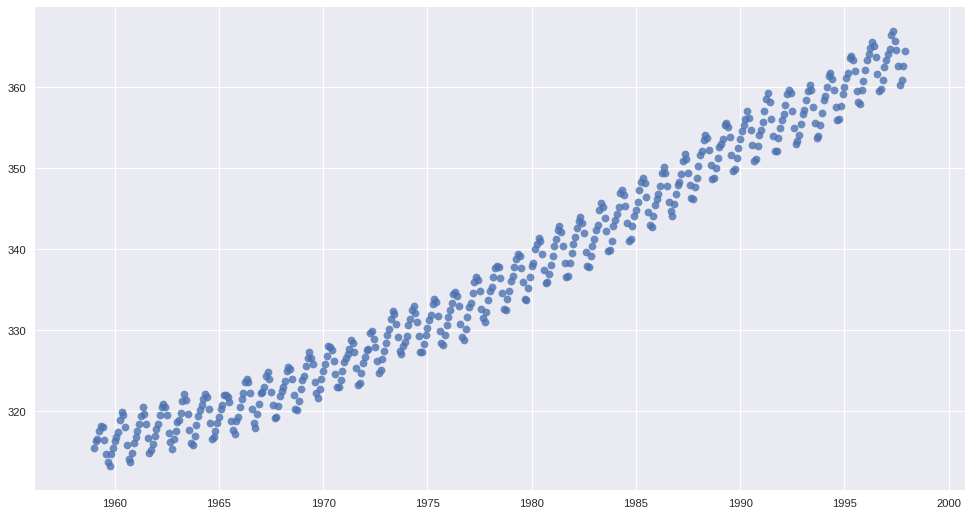

In [3]:
fig=plt.figure(figsize=(15, 8), dpi= 80, facecolor='w', edgecolor='k')
sns.regplot(x, y, fit_reg=False)

In [4]:
k1 = GPflow.kernels.RBF(1, variance=(66.0 ** 2), lengthscales=67.0)
k2_exp_sine_squred_gamma= 2.0 / 1.3 ** 2
k2_exp_sine_squred_period = 1.0
k2 = GPflow.kernels.RBF(1, variance=(2.4 ** 2), lengthscales=90) * GPflow.kernels.PeriodicKernel(1, period=k2_exp_sine_squred_period, variance=1.0, lengthscales=1/k2_exp_sine_squred_gamma)
# k3 = how to do a rational quadratic term in GPflow?
k4 = GPflow.kernels.RBF(1, variance=(0.18 ** 2), lengthscales=1.6) + GPflow.kernels.White(1, variance=0.19)

kernel = k1 + k2 + k4

m = GPflow.gpr.GPR(X, Y, kern=kernel)
m.likelihood.variance = 0.01
m

Name,values,prior,constraint
name.kern.prod.periodickernel.lengthscales,[ 0.845],None,+ve
name.kern.prod.periodickernel.period,[ 1.],None,+ve
name.kern.prod.periodickernel.variance,[ 1.],None,+ve
name.kern.prod.rbf.lengthscales,[ 90.],None,+ve
name.kern.prod.rbf.variance,[ 5.76],None,+ve
name.kern.rbf_1.lengthscales,[ 67.],None,+ve
name.kern.rbf_1.variance,[ 4356.],None,+ve
name.kern.rbf_2.lengthscales,[ 1.6],None,+ve
name.kern.rbf_2.variance,[ 0.0324],None,+ve
name.kern.white.variance,[ 0.19],None,+ve


In [5]:
%%time
m.optimize()

CPU times: user 50.9 s, sys: 5.9 s, total: 56.8 s
Wall time: 11.6 s


      fun: 129.03234853639407
 hess_inv: <11x11 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.03641972,  0.16268957, -0.00595096, -0.04949717, -0.00168133,
       -0.00410956, -0.0048979 , -0.0083654 , -0.01864009, -0.05637233,
       -0.01805678])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 225
      nit: 157
   status: 0
  success: True
        x: array([ -4.43667059e-02,   5.40852692e-01,   5.82720451e-01,
         9.18896168e+01,   5.63757395e+00,   4.85940092e+01,
         4.35621927e+03,  -9.48604462e-01,  -1.74924228e+00,
        -3.42579060e+00,  -4.58611302e+00])

In [6]:
m

Name,values,prior,constraint
name.kern.prod.periodickernel.lengthscales,[ 0.67121086],None,+ve
name.kern.prod.periodickernel.period,[ 0.99970256],None,+ve
name.kern.prod.periodickernel.variance,[ 1.02636651],None,+ve
name.kern.prod.rbf.lengthscales,[ 91.88961784],None,+ve
name.kern.prod.rbf.variance,[ 5.64113012],None,+ve
name.kern.rbf_1.lengthscales,[ 48.59401021],None,+ve
name.kern.rbf_1.variance,[ 4356.21926937],None,+ve
name.kern.rbf_2.lengthscales,[ 0.3273468],None,+ve
name.kern.rbf_2.variance,[ 0.16033736],None,+ve
name.kern.white.variance,[ 0.03200686],None,+ve


In [7]:
def plot(m, with_data=True):
    if not isinstance(m, list):
        m = [m]
    predictions = [model.predict_y(xx) for model in m]
    if with_data:
        plt.plot(X, Y, 'kx', mew=2)
    for mean, var in predictions:
        line, = plt.plot(xx, mean, lw=2)
        plt.fill_between(xx[:,0], mean[:,0] - 2*np.sqrt(var[:,0]), mean[:,0] + 2*np.sqrt(var[:,0]), color=line.get_color(), alpha=0.2)

As you can see in the below figure the complete model matches nicely.

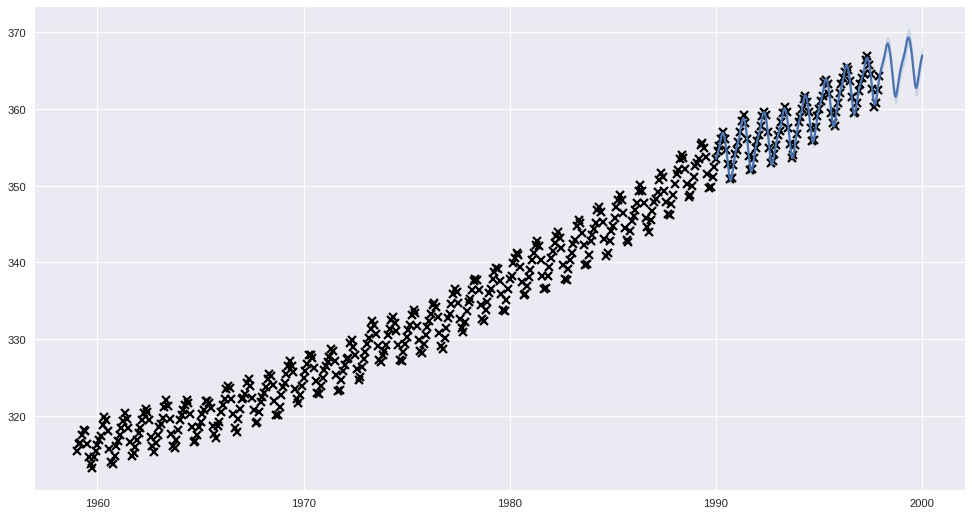

In [8]:
xx = np.linspace(1990, 2000, 1000).reshape(-1,1)
fig=plt.figure(figsize=(15, 8), dpi= 80, facecolor='w', edgecolor='k')
plot(m)

Now let's split the model into components and create model $m_1$ (blue) with only the long term trend and model $m_2$ (green) with only the product term of [p.120](http://www.gaussianprocess.org/gpml/chapters/RW5.pdf):
$$
\begin{eqnarray}
k_2(x,x')&=&\theta_3^2\cdot\hbox{exp}\left(-\frac{(x-x')^2}{2\theta_4^2}-\frac{2\sin^2(\pi(x-x')/1.0)}{\theta_5^2}\right)\\
&=&\left(\theta_3^2\cdot\hbox{exp}\left(-\frac{(x-x')^2}{2\theta_4^2}\right)\right)\cdot\left(1.0\cdot\hbox{exp}\left(-\frac{2\sin^2(\pi(x-x')/1.0)}{\theta_5^2}\right)\right)
\end{eqnarray}
$$

Where $\theta_3$ is the `variance` term in the `RBF` kernel and therefore the `variance` term in the `PeriodicKernel` kernel will be $1.0$.

In [9]:
k1 = GPflow.kernels.RBF(1, variance=m.kern.rbf_1.variance.value, lengthscales=m.kern.rbf_1.lengthscales.value)
m1 = GPflow.gpr.GPR(X, Y, kern=k1)
m1.likelihood.variance = m.likelihood.variance.value
m1.fixed = True

k2 = GPflow.kernels.RBF(1, variance=m.kern.prod.rbf.variance.value, lengthscales=m.kern.prod.rbf.lengthscales.value) \
    * \
    GPflow.kernels.PeriodicKernel(1, period=m.kern.prod.periodickernel.period.value, 
                                  variance=m.kern.prod.periodickernel.variance.value, 
                                  lengthscales=m.kern.prod.periodickernel.lengthscales.value)
m2 = GPflow.gpr.GPR(X, Y, kern=k2)
m2.likelihood.variance = m.likelihood.variance.value
m2.fixed = True

k1 = GPflow.kernels.RBF(1, variance=m.kern.rbf_1.variance.value, lengthscales=m.kern.rbf_1.lengthscales.value)
k2 = GPflow.kernels.RBF(1, variance=m.kern.prod.rbf.variance.value, lengthscales=m.kern.prod.rbf.lengthscales.value) \
    * \
    GPflow.kernels.PeriodicKernel(1, period=m.kern.prod.periodickernel.period.value, 
                                  variance=m.kern.prod.periodickernel.variance.value, 
                                  lengthscales=m.kern.prod.periodickernel.lengthscales.value)
m3 = GPflow.gpr.GPR(X, Y, kern=(k1+k2))
m3.likelihood.variance = m.likelihood.variance.value
m3.fixed = True

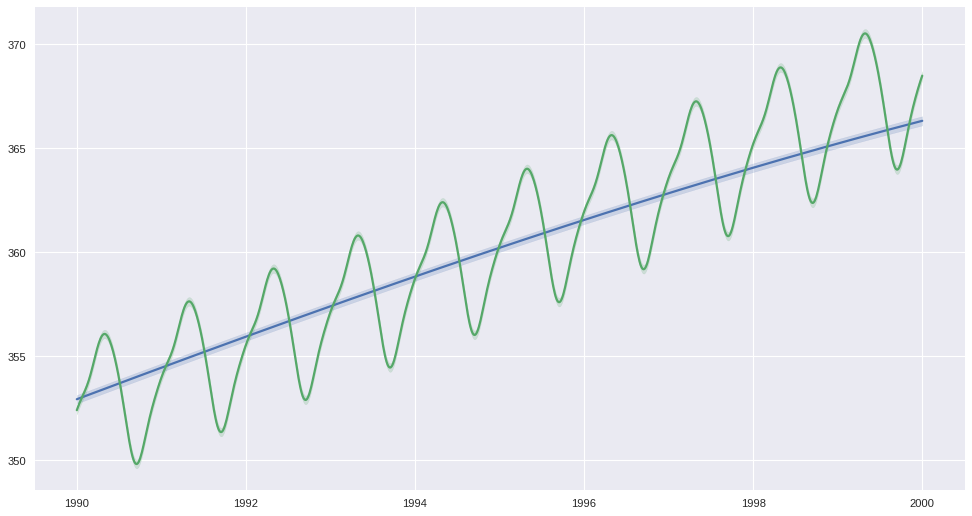

In [10]:
fig=plt.figure(figsize=(15, 8), dpi= 80, facecolor='w', edgecolor='k')
plot([m1, m2], with_data=False)

And if we then plot $m_1$ (blue) and $m_2$ (green) and the combined/full model $m_3$ (red) in the same graph we get the picture below.

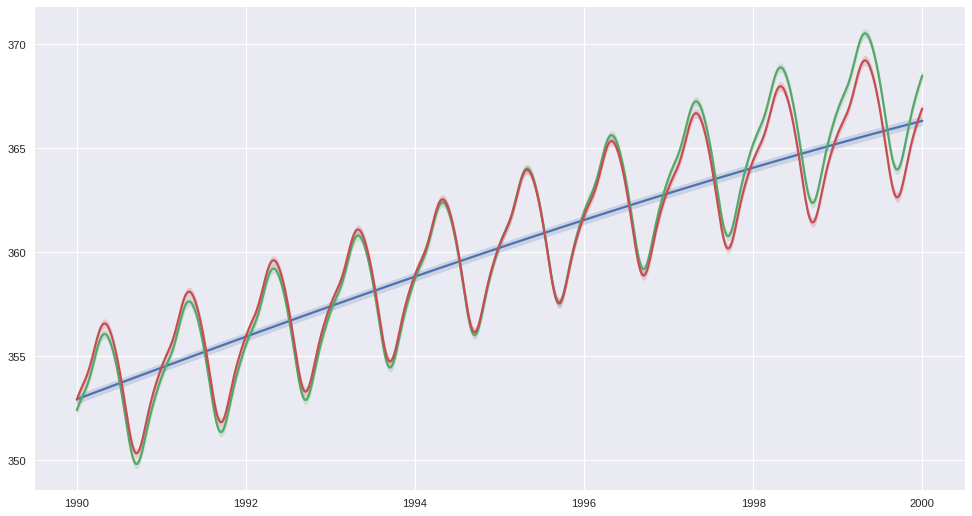

In [11]:
fig=plt.figure(figsize=(15, 8), dpi= 80, facecolor='w', edgecolor='k')
plot([m1, m2, m3], with_data=False)

Now this is confusing me. Most likely this will be due to a general misunderstanding on my part. But I was thinking that the green line would be added ontop of the blue line and therefore the red line cannot be more or less the same as the green line??

In addition, how do I then get the [Figure 5.7 (b)](http://www.gaussianprocess.org/gpml/chapters/RW5.pdf) and also for the different years as shown for 1958, 1970 and 2003 (besides the fact that my data from above does not go that far).